## Introdução e configuração

In [1]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

Vamos importar a biblioteca tabular fastai, definir uma semente (seed) aleatória para que o notebook seja reproduzível e escolher um número razoável de algarismos significativos para exibir em nossas tabelas:

In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Preparando os dados

Vamos ler o arquivo CSV:

In [3]:
df = pd.read_csv(path/'train.csv')

Quando você faz tudo do zero, cada parte da engenharia de recursos exige muito trabalho, já que você precisa pensar em coisas como variáveis fictícias (dummy), normalização, valores ausentes e assim por diante. Mas com fastai tudo isso é feito para você.

In [4]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

Podemos usar `RandomSplitter` para separar os conjuntos de treinamento e validação:

In [5]:
splits = RandomSplitter(seed=42)(df)

Agora, todo o processo de preparação dos dados para treinamento requer apenas esta célula:

In [6]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

Veja o que cada um dos parâmetros significa:

- Use `splits` para índices de conjuntos de treinamento e validação:

      splits=splits,
    
- Transforme strings em categorias, preencha os valores ausentes em colunas numéricas com a mediana, normalize todas as colunas numéricas:
    
      procs = [Categorify, FillMissing, Normalize],
    
- Estas são as variáveis independentes categóricas:
    
      cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    
- Estas são as variáveis independentes contínuas:
    
      cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    
- Esta é a variável dependente:
    
      y_names="Survived",

- A variável dependente é categórica (portanto, construa um modelo de classificação, não um modelo de regressão):

      y_block = CategoryBlock(),

## Treine o modelo

Os dados e o modelo juntos formam um 'Aprendiz'. Para criar um, dizemos quais são os dados (`dls`) e o tamanho de cada camada oculta (`[10,10]`), juntamente com as métricas que queremos imprimir ao longo do caminho:

In [7]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

Você notará que não precisamos fazer nenhuma confusão para tentar encontrar um conjunto de coeficientes aleatórios que serão treinados corretamente - tudo é tratado automaticamente.

Um recurso útil que o fastai também pode nos dizer qual taxa de aprendizado usar:

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

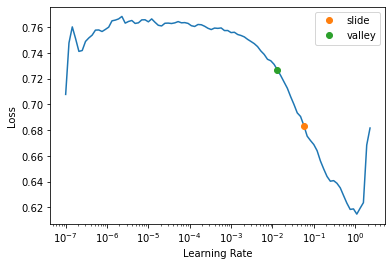

In [8]:
learn.lr_find(suggest_funcs=(slide, valley))

Os dois pontos coloridos são escolhas razoáveis para uma taxa de aprendizado. Vou escolher algo entre os dois (0,03) e treinar por algumas vezes:

In [9]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.577146,0.582949,0.606742,00:00
1,0.510818,0.498523,0.786517,00:00
2,0.467023,0.459841,0.797753,00:00
3,0.439957,0.468547,0.797753,00:00
4,0.427232,0.415261,0.825843,00:00
5,0.416340,0.437362,0.820225,00:00
6,0.408347,0.413253,0.848315,00:00
7,0.400442,0.406075,0.803371,00:00
8,0.397265,0.443730,0.820225,00:00
9,0.392389,0.432267,0.831461,00:00


## Enivar para o Kaggle

Uma característica importante do fastai é que todas as informações necessárias para aplicar as transformações de dados e o modelo a um novo conjunto de dados são armazenadas no aprendiz. Você pode chamar `export` para salvá-lo em um arquivo para usá-lo posteriormente na produção ou pode usar o modelo treinado imediatamente para obter previsões em um conjunto de teste.

Para enviar ao Kaggle, precisaremos ler no conjunto de teste e fazer a mesma engenharia de recursos que fizemos para o conjunto de treinamento:

In [10]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

Mas não precisamos especificar manualmente nenhuma das etapas de processamento necessárias para preparar os dados para modelagem, pois tudo é salvo no aprendiz. Para especificar que queremos aplicar as mesmas etapas a um novo conjunto de dados, use o método `test_dl()`:

In [11]:
tst_dl = learn.dls.test_dl(tst_df)

Agora podemos usar `get_preds` para obter as previsões para o conjunto de teste:

In [12]:
preds,_ = learn.get_preds(dl=tst_dl)

Por fim, vamos criar um CSV de envio...

In [13]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

...e verificar se parece razoável:

In [14]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Montagem

Já que é tão fácil criar um modelo agora, é mais fácil brincar com abordagens de modelagem mais avançadas. Por exemplo, podemos criar cinco modelos separados, cada um treinado a partir de diferentes pontos iniciais aleatórios, e tirar a média deles. Essa é a abordagem mais simples de modelos [conjunto](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/), que combina vários modelos para gerar previsões melhores do que qualquer um dos modelos individuais do conjunto.

Para criar nosso ensemble, primeiro copiamos as três etapas que usamos acima para criar e treinar um modelo e aplicá-lo ao conjunto de teste:

In [15]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

Agora, executamos isso cinco vezes e coletamos os resultados em uma lista:

In [16]:
learns = [ensemble() for _ in range(5)]

Nós empilhamos essas previsões e tomamos suas previsões médias:

In [17]:
ens_preds = torch.stack(learns).mean(0)

Por fim, geramos um arquivo de envio, que podemos enviar ao Kaggle depois que o notebook for salvo e executado:

In [18]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)